# MNIST Classification with CNN -- High Level API (tf.keras) --
In this notebook, I describe how to implement CNN using tf.keras API.

In [1]:
import tensorflow as tf
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("scikit learn version: ", sklearn.__version__)
print("matplotlib version: ", matplotlib.__version__)

tf.enable_eager_execution()

tensorflow version:  1.15.2
numpy version:  1.18.2
scikit learn version:  0.22.2.post1
matplotlib version:  3.2.0


## 1. Load data & preprocessing
In this notebook, I use pre-defined mnist dataset.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Split original training dataset into train/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [4]:
# Normalize Intensity
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [5]:
# Convert into 4d tensor shape
X_train = X_train.reshape((*X_train.shape, 1))
X_val = X_val.reshape((*X_val.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

In [6]:
# Convert labels into one-hot encoding (float)
y_train = np.float32(tf.keras.utils.to_categorical(y_train))
y_val = np.float32(tf.keras.utils.to_categorical(y_val))
y_test = np.float32(tf.keras.utils.to_categorical(y_test))

## 2. Create tf.data.Dataset

In [8]:
train_batch_size = 64
test_batch_size = 1

# Build source dataset for training
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(train_batch_size).repeat()

# Build source dataset for validation
X_valid_dataset = tf.data.Dataset.from_tensor_slices(X_val)
y_valid_dataset = tf.data.Dataset.from_tensor_slices(y_val)
validation_dataset = tf.data.Dataset.zip((X_valid_dataset, y_valid_dataset)).batch(train_batch_size).repeat()

# Build source dataset for test
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(test_batch_size).repeat()

Debug dataset

In [9]:
def visualize_batch(X_batch, y_batch, y_pred=None):
    assert len(X_batch) == len(y_batch)
    
    n_col = 10
    if len(X_batch) % n_col ==0:
        n_row=len(X_batch)//n_col
    else:
        n_row=len(X_batch)//n_col + 1
    
    fig = plt.figure(figsize=(20,15))
    
    for idx in range(len(y_batch)):
        if y_pred is not None:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}, pred={}".format(np.argmax(y_batch[idx]), y_pred[idx]))
        else:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}".format(np.argmax(y_batch[idx])))
        ax.imshow(X_batch[idx].reshape(28,28), cmap='gray')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()

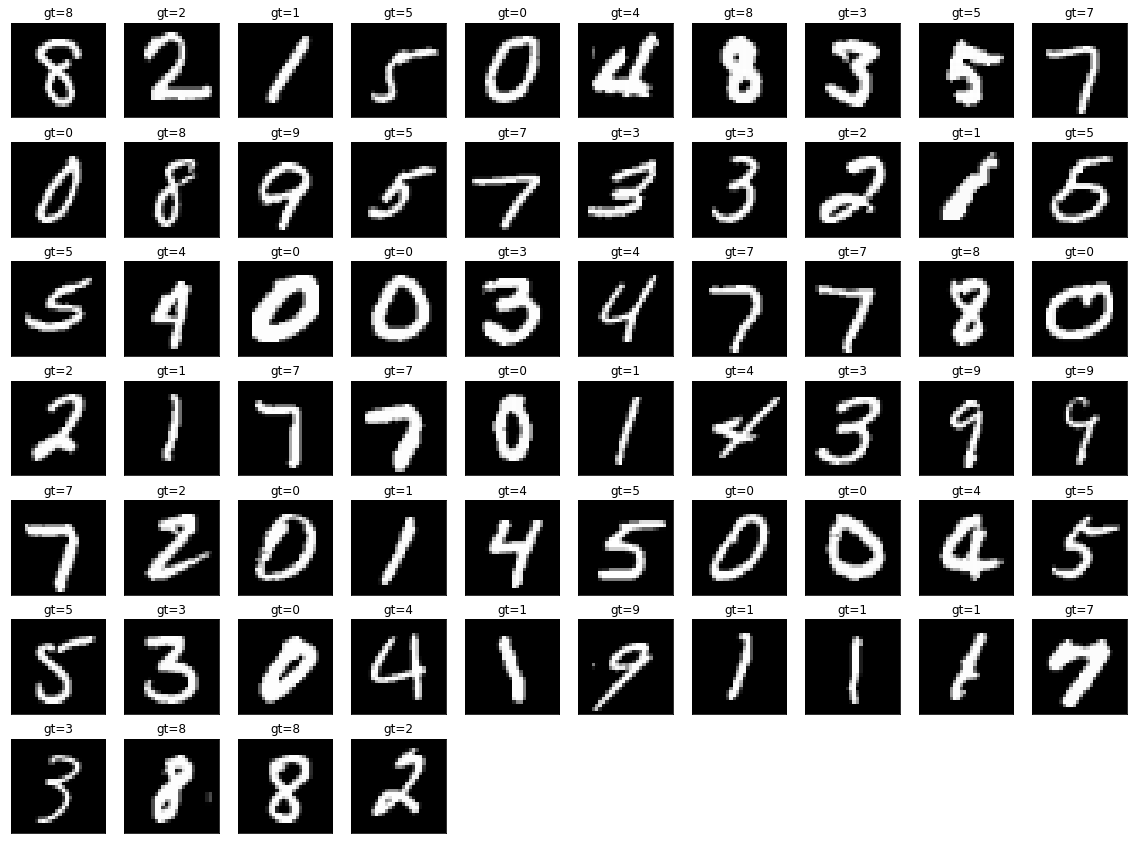

In [10]:
for X_batch, y_batch in train_dataset:
    visualize_batch(X_batch.numpy(), y_batch.numpy())
    break

## 3. Create CNN model
Network structure:
[CONV(32) - BN - RELU] - MAXPOOL - [CONV(64) - BN - RELU] - MAXPOOL - [FC(1024) - BN - RELU] - DROPOUT - FC(10) - SOFTMAX

The weight initialization rule are following:  
- Layer with relu activation: He initialization  
- Others: Xavier initialization  

### Define network
By creating model as an inherited class of tf.keras.Model, we can easily train model by fit() method. 

In [13]:
class ConvNet(tf.keras.Model):
    def __init__(self, conv_filters=[32, 64], dense_node=1024, num_class=10, dropout_rate=0.2):
        super(ConvNet, self).__init__(name="ConvNet")
        self.conv1 = tf.keras.layers.Conv2D(conv_filters[0], 3, 1, 'same', 
                                            kernel_initializer=tf.keras.initializers.he_normal())
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.Activation("relu")
        self.pool1 = tf.keras.layers.MaxPool2D(2, 2, padding="same")
        
        self.conv2 = tf.keras.layers.Conv2D(conv_filters[1], 3, 1, 'same', 
                                            kernel_initializer=tf.keras.initializers.he_normal())
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.Activation("relu")
        self.pool2 = tf.keras.layers.MaxPool2D(2, 2, padding="same")
        
        self.flattern = tf.keras.layers.Flatten()

        self.dense3 = tf.keras.layers.Dense(dense_node, kernel_initializer=tf.keras.initializers.he_normal())
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.Activation("relu")
        
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        
        self.dense4 = tf.keras.layers.Dense(num_class, kernel_initializer=tf.keras.initializers.glorot_normal())
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = self.bn1(x, training)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flattern(x)
        
        x = self.dense3(x)
        x = self.bn3(x, training)
        x = self.relu3(x)
        
        if training:
            x = self.dropout(x)
        
        x = self.dense4(x)
        
        return x

## 4. Training

In [14]:
lr = 0.001
epochs = 15
checkpoint_path = './checkpoints_3/model_{epoch:04d}.ckpt'

model = ConvNet()
model.compile(optimizer=tf.train.AdamOptimizer(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_freq='epoch'),
]

model.fit(train_dataset, epochs=epochs, steps_per_epoch=int(len(X_train)/train_batch_size),
          validation_data=validation_dataset, validation_steps=int(len(X_val)/train_batch_size), callbacks=callbacks)

Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
750/750 [==============================] - 29s 39ms/step - loss: 0.0206 - acc: 0.9851 - val_loss: 0.0134 - val_acc: 0.9953
Epoch 2/15
750/750 [==============================] - 28s 38ms/step - loss: 0.0069 - acc: 0.9972 - val_loss: 0.0113 - val_acc: 0.9959
Epoch 3/15
750/750 [==============================] - 28s 38ms/step - loss: 0.0041 - acc: 0.9985 - val_loss: 0.0150 - val_acc: 0.9952
Epoch 4/15
750/750 [==============================] - 28s 38ms/step - loss: 0.0026 - acc: 0.9990 - val_loss: 0.0090 - val_acc: 0.9973
Epoch 5/15
750/750 [==============================] - 28s 38ms/step - loss: 0.0021 - acc: 0.9993 - val_loss: 0.0104 - val_acc: 0.9969
Epoch 6/15
750/750 [==============================] - 28s 38ms/step - loss: 0.0017 - acc: 0.9993 - val_loss: 0.0103 - val_acc: 0.9972
Epoch 7/15
750/750 [==============================] - 28s 38ms/step - loss: 0.0013 - acc: 0.9995 - val

## 5. Test

In [15]:
model.evaluate(test_dataset, steps=len(y_test))

10000/10000 [==============================] - 78s 8ms/step - loss: 0.0092 - acc: 0.9974


[0.00920389838141409, 0.9974495]

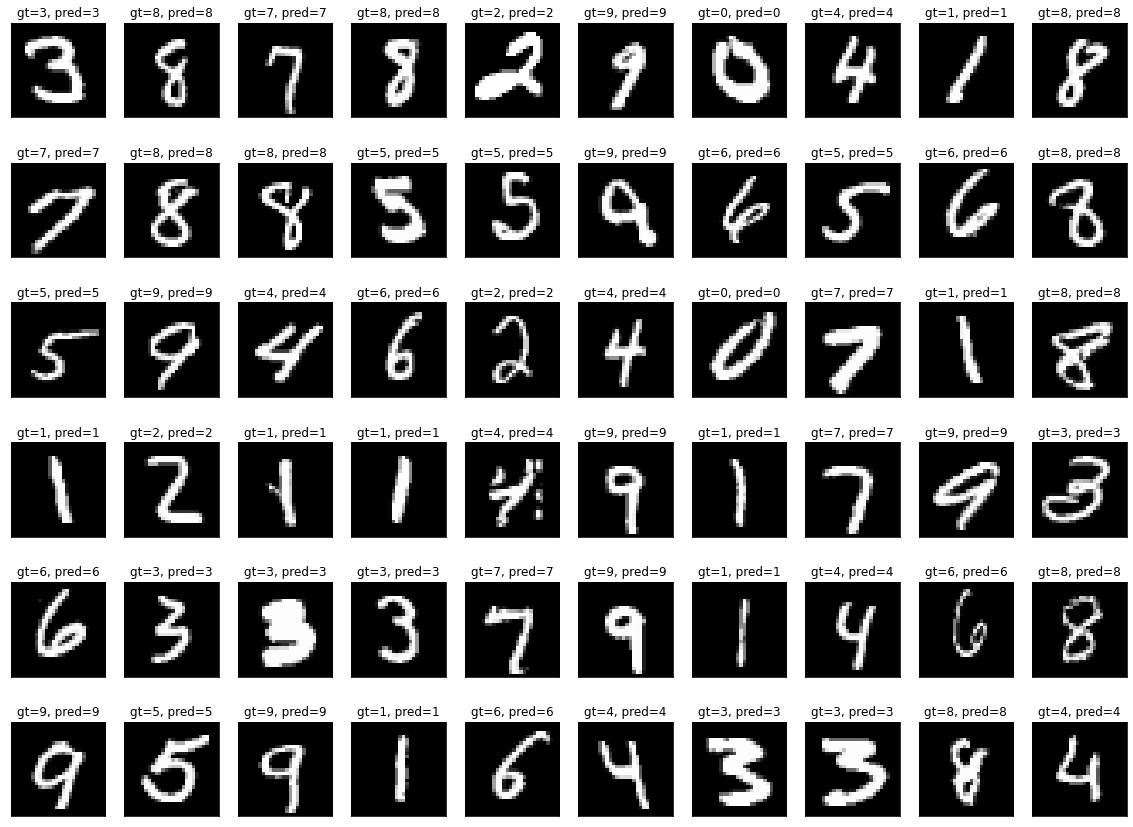

In [19]:
index = np.random.choice(np.arange(0, len(y_test)), size=60)
test_input = X_test[index]
y_true = y_test[index]

predicted = model.predict(test_input)
predicted_label = np.argmax(predicted, axis=1)

visualize_batch(test_input, y_true, predicted_label)